# Working with Time Series Data

**Table of contents**<a id='toc0_'></a>    
- [Import Statements](#toc1_)    
- [Reading Time Data and Handling Timezone Information](#toc2_)    
  - [*Basic informations and some knowhows about Timezones*](#toc2_1_)    
  - [*Working with UTC time data*](#toc2_2_)    
  - [*Working with Local time data*](#toc2_3_)    
  - [*Working with UNIX Epoch time*](#toc2_4_)    
- [The `.dt` Accessor](#toc3_)    
  - [*The `dt.strftime()` method*](#toc3_1_)    
- [Dates in the Index](#toc4_)    
    - [*Finding missing data*](#toc4_1_1_)    
    - [*Handling Missing data*](#toc4_1_2_)    
  - [*Shifting Data*](#toc4_2_)    
  - [*Rolling window calculations*](#toc4_3_)    
- [Resampling](#toc5_)    
    - [Using the `.transform()` method on a `Resampler` Object](#toc5_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=4
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Import Statements](#toc0_)

--------------------------

In [1]:
# import statements
import numpy as np
import pandas as pd

In [2]:
# view options
pd.set_option("display.max_columns", 14)
pd.set_option("display.max_rows", 4)

---------------------------

## <a id='toc2_'></a>[Reading Time Data and Handling Timezone Information](#toc0_)

-----------------------

### <a id='toc2_1_'></a>[*Basic informations and some knowhows about Timezones*](#toc0_)

Coordinated Universal Time (UTC) is the time standard at 0 degrees longitude. It has an excellent property, that it is monotonically increasing. For example, Salt Lake City, Utah is in the America/Denver timezone, which is 6 or 7 hours offset of UTC depending on the time of
year (due to Day light saving). Thus we see, a timezone may contain one or more offsets.

**Some terminologies:** A time without a timezone or offset is called ”naive” time. A time specified in local time is also called ”civil time” or ”wall time”.

Timezones that have daylight savings time can have ”ambiguous time” in the fall when the time goes back. For this reason, if you are dealing with **local times**, you will want three things: **the time, the timezone, and an offset**. If you are only concerned with **duration**, you can just use **UTC time** or seconds since **UNIX epoch**.

A general recommendation for programmers is to store dates in UTC times and then convert them to local time as needed.


Getting the correct timezone name is important. The recommendation is prefacing your search with ”IANA” (ie. ”IANA Timezone for Salt Lake City”) and then double checking your result in this Wikipedia article (https://en.wikipedia.org/wiki/List_of_tz_database_time_zones).

### <a id='toc2_2_'></a>[*Working with UTC time data*](#toc0_)

In [3]:
# ./utc_time_data.csv contains made up data
utc_data = pd.read_csv("./utc_time_data.csv").UTC_Date

In [4]:
utc_data

0     2015 -03 -08 08:00:00-07:00
1     2015 -03 -08 08:30:00-07:00
                 ...             
12    2015 -11 -01 09:30:00-07:00
13    2015 -11 -01 10:00:00-07:00
Name: UTC_Date, Length: 14, dtype: object

- ##### The `pd.to_datetime(args, utc, format)` Function

The pd.to_datetime() mehod converts specified iterables (columns of a DataFrame, list etc.) to Pandas DateTimeIndex object.

The format argument is used if the time has a certain pattern in its representation.

The available format codes can be found here : https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

To convert a series containing **utc date into a datetime64** object, we can use the `pd.to_datetime()` function and we also need to set, **utc=True**.

In [5]:
utc_time = pd.to_datetime(utc_data, utc=True)

In [6]:
utc_time

0    2015-03-08 15:00:00+00:00
1    2015-03-08 15:30:00+00:00
                ...           
12   2015-11-01 16:30:00+00:00
13   2015-11-01 17:00:00+00:00
Name: UTC_Date, Length: 14, dtype: datetime64[ns, UTC]

**Note:** It is `not necessary` that the UTC data has an `offset of 00:00`. Setting, `utc=True` will `automatically convert` the data to an `offset of 00:00`. 

If we need, we can change it using the .dt.tz_convert(timezone) method.

Once we have converted a series to a datetime object we can utilize the `.dt` accessor, which gives us some awesome tools for dealing with dates.

- ##### Converting to a different timezone, The `.dt.tz_convert(timezone)` method

To convert UTC datetime data to a certain timezone we can use the `.dt.tz_convert()` method.

In [7]:
# say, we wanted to convert the utc_time to the Dhaka timezone (capital of Bangladesh)
# from internet we determine that the correct timezone for Dhaka is, 'Asia/Dhaka'
utc_time.dt.tz_convert("Asia/Dhaka")

0    2015-03-08 21:00:00+06:00
1    2015-03-08 21:30:00+06:00
                ...           
12   2015-11-01 22:30:00+06:00
13   2015-11-01 23:00:00+06:00
Name: UTC_Date, Length: 14, dtype: datetime64[ns, Asia/Dhaka]

### <a id='toc2_3_'></a>[*Working with Local time data*](#toc0_)

To load local date information, we need to have the **date, the offset, and the timezone** all three.

In [8]:
local = pd.read_csv("./local_time_data.csv")
local_date_time = local.local_date_time
offset = local.offset

In [9]:
local_date_time

0     2015 -03 -08 01:00:00
1     2015 -03 -08 01:30:00
              ...          
17    2015 -11 -01 02:30:00
18    2015 -11 -01 03:00:00
Name: local_date_time, Length: 19, dtype: object

<u>**Workflow:**</u>

1. First, we will convert the 'local_date_time' to a naive (i.e, w/o timezone information) datetime format using the `pd.to_datetime()` function.
2. We will group the 'local_date_time' datetime object by the offset.
    - If we pass in a series to a `groupby` object it will first align the passed series to the original data [much like adding a new column to the data] (it will enter NaN at the end if series length is smaller than the length of the dataframe). 
    - After that, the actual grouping will be done. The groups will have the series value (that it was grouped by) as its name (accessible by `grp.name`).
3. To retain the original index positions we will be using the groupby `.transform()` method instead of the `.agg()` method. 
4. After that, the naive date data will be converted to a `timezone-aware` format with the help of, `.dt.tz_localize(tz:str, pytz.timezone)` method.
5. Finally we will be converting the timezone-aware object to the local timezone using the `.dt.tz_convert()` method.

One caveat in this process is that, our offset series doesn't have the proper timezone format i,e, `HH:MM`. As a result if we tried to produce a timezone aware datetime object it will only modify the MM and not the HH. So, first we convert the offset series entries to proper format. 

In [10]:
# see that, offset doesn't have the proper formatting
# offset.sample(2)

In [11]:
# formatting offset series entries to HH:MM
offset = offset.replace({-7: "-07:00", -6: "-06:00"})

In [12]:
# see what changed after formatting
# offset.sample(2)

In [13]:
# The actual work starts here (we will convert the time to America/Denver timezone)

local_time = (
    pd.to_datetime(local_date_time, format="mixed")
    .groupby(offset)
    .transform(
        lambda grp_: grp_.dt.tz_localize(grp_.name).dt.tz_convert("America/Denver")
    )
)

In [14]:
local_time

0    2015-03-08 01:00:00-07:00
1    2015-03-08 01:30:00-07:00
                ...           
17   2015-11-01 02:30:00-07:00
18   2015-11-01 03:00:00-07:00
Name: local_date_time, Length: 19, dtype: datetime64[ns, America/Denver]

In [15]:
# pd.to_datetime(local_date_time).groupby(offset).transform(lambda grp_s_: print(grp_s_.name))

- Converting local time to UTC

In [16]:
local_time.dt.tz_convert("UTC")

0    2015-03-08 08:00:00+00:00
1    2015-03-08 08:30:00+00:00
                ...           
17   2015-11-01 09:30:00+00:00
18   2015-11-01 10:00:00+00:00
Name: local_date_time, Length: 19, dtype: datetime64[ns, UTC]

### <a id='toc2_4_'></a>[*Working with UNIX Epoch time*](#toc0_)

- To find the time elapsed (in seconds) since UNIX epoch at Jan 1, 1970 midnight UTC -

In [17]:
unix_local = local_time.view(int).floordiv(1e9).astype(int)
unix_local

0     1425801600
1     1425803400
         ...    
17    1446370200
18    1446372000
Name: local_date_time, Length: 19, dtype: int64

- To convert epoch information into UTC -

In [18]:
pd.to_datetime(unix_local, unit="s").dt.tz_localize("UTC")

0    2015-03-08 08:00:00+00:00
1    2015-03-08 08:30:00+00:00
                ...           
17   2015-11-01 09:30:00+00:00
18   2015-11-01 10:00:00+00:00
Name: local_date_time, Length: 19, dtype: datetime64[ns, UTC]

**Note:** In UNIX time format, leap seconds are ignored, with a leap second having the same Unix time as the second before it, and every day is treated as if it contains exactly 86400 seconds. Due to this treatment, Unix time is not a true representation of UTC.

--------------------------------------------

## <a id='toc3_'></a>[The `.dt` Accessor](#toc0_)

-------------------------------------------

The .dt accessor provides us access to some very useful datatime properties and mehtods.

DateTime properties: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetime-properties

DateTime methods: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#datetime-methods

Period properties: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#period-properties 

TimeDelta properties: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#timedelta-properties

TimeDelta methods: https://pandas.pydata.org/pandas-docs/stable/reference/series.html#timedelta-methods

In [19]:
# For example to calculate year, week, and day according to the ISO 8601 standard
local_time.dt.isocalendar()

,year,week,day
0,2015,10,7
1,2015,10,7
...,...,...,...
17,2015,44,7
18,2015,44,7


### <a id='toc3_1_'></a>[*The `dt.strftime()` method*](#toc0_)

The `.dt.strftime(format)` method will convert a pandas datetime object to a string using the specified formatting style. To see all the available format codes see the documentation @https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes

In [20]:
# for example, let's say we want our local_time series data as a string in the form of
# e.g, 03 Jan 2000 02:44 PM MDT
local_time.dt.strftime("%d %b %Y %I:%M %p %Z").head(3)

0    08 Mar 2015 01:00 AM MST
1    08 Mar 2015 01:30 AM MST
2    08 Mar 2015 03:00 AM MDT
Name: local_date_time, dtype: object

----------------------

## <a id='toc4_'></a>[Dates in the Index](#toc0_)

---------------------

First let us read in the alta-noaa-1980-2019.csv dataset. This dataset contains information about the amount of snow fall in a ski resort.

In [21]:
alta_df = pd.read_csv("./Data/alta-noaa-1980-2019.csv", date_format="DATE").set_index(
    "DATE"
)
alta_df.index = alta_df.index.astype("datetime64[ns]")

In [22]:
alta_df_snow = alta_df.SNOW.rename("snow")
alta_df_snow

DATE
1980-01-01    2.0
1980-01-02    3.0
             ... 
2019-09-06    0.0
2019-09-07    0.0
Name: snow, Length: 14160, dtype: float64

- Slicing Time series

As the index is a datetime object, we can slice it with a string (or a partial string) that represents the date. If we specify just the month on a slice, it includes all entries from that month (on both the start and end slices).

In [23]:
alta_df_snow.loc["1980/2":"1980/3"]

DATE
1980-02-01     0.0
1980-02-02     0.0
              ... 
1980-03-30     0.0
1980-03-31    13.0
Name: snow, Length: 60, dtype: float64

#### <a id='toc4_1_1_'></a>[*Finding missing data*](#toc0_)

In [24]:
# at first, let us check whether the data has any missing values at all
alta_df_snow.isna().any()

True

In [25]:
# looks like it indeed has missing values. let's create a filter to see which dates has missing values
alta_df_snow.loc[alta_df_snow.isna()]

DATE
1985-07-30   NaN
1985-09-12   NaN
              ..
2017-12-23   NaN
2018-12-03   NaN
Name: snow, Length: 365, dtype: float64

**Note:** The series object has no `.query` method. If it was a dataframe then we could have used the .query() method.

#### <a id='toc4_1_2_'></a>[*Handling Missing data*](#toc0_)

**The best way to deal with missing data is to talk with a subject matter expert and determine why it is missing.**

- <u>**Dropping missing values**</u> with the `dropna()` method

Be careful with the method and only use it after talking to a subject matter expert who confirms that it is ok to drop the data. It can be hard to tell later if the data is missing. For example, if you plotted this data, you might not see that data was dropped unless you pay close attention.

In [26]:
alta_df_snow.dropna().isna().any()

False

- <u>**Filling missing values**</u> with the help of `.fillna()`, `.ffill()`, `.bfill()` etc. 

Depending on the data contents, the `.mean()`, `.mode()`, `.median` and other such methods may come in handy while using the `.fillna()` method.

- <u>**Interpolating missing values**</u> with the `.interpolate()` method may also be appropriate in some cases. By default the interpolating method will be linear interpolation.

- <u>**Using filling and interpolation in combination**</u> with the help of `.where()`/`.mask()` method

As is often the case, the trend and characteristics of the data is such that handling missing values requires us to utilize different methods for different parts of the data. Our `alta_df_snow` data series is a good example of this. 

-> In winter (1st and 4th quarter of the year) we should use interpolate/ffill/bfill methods. As, in winter it is most likey that there were snow in the days that are missing the data.

-> But, in summer (2nd and 3rd quarter of the year) we can assume that there were no snow and thus use fillna method to fill the missing values with 0.

To find out which quarter a date (datetime object) falls on we can call the `.dt.quarter` property. In case of DateTimeIndex object we can directly call the `.quarter` property to serve the same purpose.

In [27]:
winter = (alta_df_snow.index.quarter == 1) | (alta_df_snow.index.quarter == 4)

alta_df_snow.mask(winter & alta_df_snow.isna(), alta_df_snow.interpolate()).mask(
    ~winter & alta_df_snow.isna(), 0
).isna().any()

False

### <a id='toc4_2_'></a>[*Shifting Data*](#toc0_)

The `.shift()` method works on any pandas series but comes in really useful with time series when we want to compare to the previous or subsequent entry.

- Forward shift

In [28]:
alta_df_snow.shift(1)

DATE
1980-01-01    NaN
1980-01-02    2.0
             ... 
2019-09-06    0.0
2019-09-07    0.0
Name: snow, Length: 14160, dtype: float64

- Backward shift

In [29]:
alta_df_snow.shift(-1)

DATE
1980-01-01    3.0
1980-01-02    1.0
             ... 
2019-09-06    0.0
2019-09-07    NaN
Name: snow, Length: 14160, dtype: float64

<AxesSubplot: xlabel='DATE'>

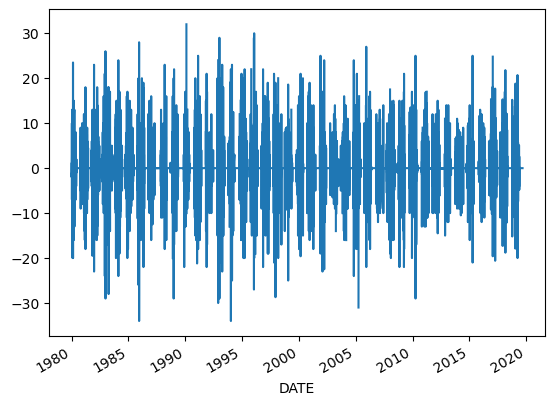

In [30]:
# For example, let's see how the snow fall trend changes as the seasons starts and ends.
# to do this, we can compare the original data with a forward shifted data
(alta_df_snow - alta_df_snow.shift(1)).plot()

### <a id='toc4_3_'></a>[*Rolling window calculations*](#toc0_)

The `.rolling()` function provides the feature of rolling window calculations. The concept of rolling window calculation is most primarily used in signal processing and time-series data. In very simple words, we take a window of size 'k' at a time and perform some desired mathematical operation on it. 

A window of size 'k' means, 'k' consecutive values at a time. In a very simple case, all the ‘k’ values are equally weighted.

<u>**.rolling() function Parameters**</u>

-> window : Size of the moving window. This is the number of observations used for calculating the statistic. Each window will be a fixed size. If its an offset then this will be the time period of each window. Each window will be a variable sized based on the observations included in the time-period. This is only valid for datetimelike indexes. To learn more about the offsets & frequency strings, please see @https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases.

-> min_periods : Minimum number of observations in window required to have a value (otherwise result is NA). For a window that is specified by an offset, this will default to 1. 

-> win_type : If win_type=none, then all the values in the window are evenly weighted. There is various other types of rolling window type. To learn more about the other rolling window types see @https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html#scipy.signal.get_window.

-> on : For a DataFrame, column on which to calculate the rolling window, rather than the index.

The aggregate functions that works on the **rolling object** are, 

<img src='./aggregate_methods_that_work_on_rolling_objects.png'>

- Example: Calculating 3 day moving average snow fall

In [31]:
alta_df_snow.rolling(window=3, min_periods=2).mean()

DATE
1980-01-01    NaN
1980-01-02    2.5
             ... 
2019-09-06    0.0
2019-09-07    0.0
Name: snow, Length: 14160, dtype: float64

------------------

## <a id='toc5_'></a>[Resampling](#toc0_)

---------------------

Resampling allows us to convert our time series data of a certain frequency to any frequency we may desire. This is specially useful for converting granular data to larger buckets. 

For example, say we have a system that outputs data each second. If we have say 6 months of this data, then it will be really hard to plot that data. Also, for various analytics we may want that data in different frequencies. For example, we may want to see the daily trend. All of this becomes very easy with the pandas `.resample()` method.

<u><b>.resample() Function Parameters</b></u>

DataFrame.resample(rule, axis=0, closed=None, label=None, convention='start', kind=None, on=None, level=None, origin='start_day', offset=None, group_keys=False)

Resample time-series data.

Convenience method for frequency conversion and resampling of time series. The object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or the caller must pass the label of a datetime-like series/index to the on/level keyword parameter.

1. `rule:` DateOffset, Timedelta or str. The offset string or object representing target conversion.
2. `closed{‘right’, ‘left’}:` Which side of bin interval is closed. The default is ‘left’ for all frequency offsets except for ‘M’, ‘A’, ‘Q’, ‘BM’, ‘BA’, ‘BQ’, and ‘W’ which all have a default of ‘right’.
3. `label{‘right’, ‘left’}:` Which bin edge label to label bucket with. The default is ‘left’ for all frequency offsets except for ‘M’, ‘A’, ‘Q’, ‘BM’, ‘BA’, ‘BQ’, and ‘W’ which all have a default of ‘right’.
4. `on:` For a DataFrame, column to use instead of index for resampling. Column must be datetime-like.

**Returns** `Resampler` Object.

Resampling generates a unique sampling distribution on the basis of the actual data. We can apply various frequency to resample our time series data. This is a very important technique in the field of analytics. Most commonly used time series frequency are – W : weekly frequency; M : month end frequency; SM : semi-month end frequency (15th and end of month); Q : quarter end frequency. 

To see a full list of format strings denoting different frequencies see, https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

Now, we will see the application of the resample method through some examples.

- Example: to find the maximum snowfall by month,

In [32]:
alta_df_snow.resample("M").max()

DATE
1980-01-31    20.0
1980-02-29    25.0
              ... 
2019-08-31     0.0
2019-09-30     0.0
Freq: M, Name: snow, Length: 477, dtype: float64

- Example: to find the maximum value for each ski season (which normally ends in May)

In [33]:
# 'A-MAY', indicates that we want an annual grouping ('A'), but ending in May of each year
alta_df_snow.resample("A-May").max()

DATE
1980-05-31    25.0
1981-05-31    26.0
              ... 
2019-05-31    20.7
2020-05-31     0.0
Freq: A-MAY, Name: snow, Length: 41, dtype: float64

#### <a id='toc5_1_1_'></a>[Using the `.transform()` method on a `Resampler` Object](#toc0_)

We can use the `.transform()` method with the resampled object, insted of applying separate aggregations functions or using the `.agg()`, in order to apply an aggregation while keeping the original index.

- Example: calculating the percentage of quarterly snowfall that fell in a particular day

In [34]:
alta_df_snow.div(alta_df_snow.resample("Q").transform("sum")).mul(100).fillna(0)

DATE
1980-01-01    0.527009
1980-01-02    0.790514
                ...   
2019-09-06    0.000000
2019-09-07    0.000000
Name: snow, Length: 14160, dtype: float64